In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [35]:
tempo_df = pd.read_csv('train.csv')
df = tempo_df.head(202145) 
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
202140,202140,304327,304328,"If you're struck once by lightning, are you mo...",Has anyone been struck by lightning 2 times or...,0
202141,202141,32375,222413,Which are some of the best places to visit?,What are the best places to visit?,1
202142,202142,201201,20121,How will the market react on scrapping Rs 500 ...,How will the stock market reacts on decision o...,1
202143,202143,304329,304330,What is binary number system?,Is binary number really binary?,0


In [36]:
df.duplicated().sum()

np.int64(0)

1.Exploratory Data Analysis on the data and plotting some important values!

<Axes: xlabel='is_duplicate', ylabel='count'>

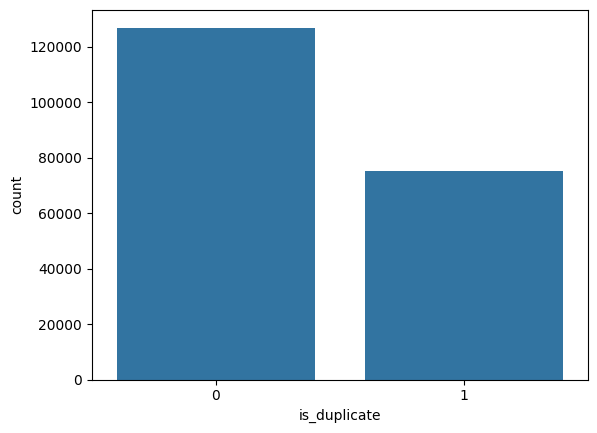

In [37]:
sns.countplot(data=df,x='is_duplicate')

In [38]:
q_ids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ids = len(np.unique(q_ids))
duplicate_ids = np.sum(q_ids.value_counts()>1)

<Axes: title={'center': 'Number of unique and duplicate questions'}>

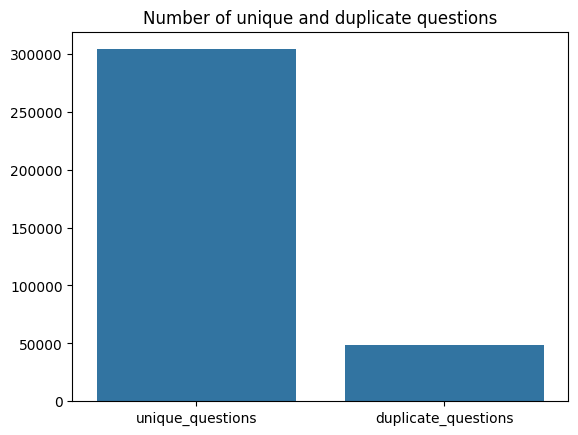

In [39]:
x = ['unique_questions','duplicate_questions']
y = [unique_ids,duplicate_ids]

plt.Figure(figsize=(10,6))
plt.title('Number of unique and duplicate questions')
sns.barplot(x=x,y=y)

2.Checking null values

In [40]:
df.isnull().sum()
df = df.fillna('')

3.Extracting and creating new features!!

In [41]:
df['q1_n'] = df['question1'].str.len()
df['q2_n'] = df['question2'].str.len()
df['q1_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
df['q2_words'] = df['question2'].apply(lambda row: len(row.split(' ')))
df['len_diff'] = abs(df['q1_words'] - df['q2_words'])

def find_common_word(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0*len(w1&w2)
def word_total_finder(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0*(len(w1)+len(w2))

df['common_words'] = df.apply(find_common_word,axis=1)
df['avg_word_len_q1'] = df['q1_n'] / df['q1_words']
df['avg_word_len_q2'] = df['q2_n'] / df['q2_words']
df['word_total'] = df.apply(word_total_finder,axis=1)




In [42]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_n,q2_n,q1_words,q2_words,len_diff,common_words,avg_word_len_q1,avg_word_len_q2,word_total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,2,10.0,4.714286,4.750000,23.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,5,4.0,6.375000,6.769231,20.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,4.0,5.214286,5.900000,24.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,2,0.0,4.545455,7.222222,19.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,6,2.0,5.846154,5.571429,20.0


4. Applying all the preprocessing techniques.

In [43]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import PorterStemmer

# Download necessary NLTK data (run this once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
def preprocessing(text):
    text = text.lower()  
    text = re.sub(r'<.*?>', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    tokens = word_tokenize(text)  
    stemmed_tokens = [ps.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens) 

In [46]:
df['question1'] = df['question1'].apply(preprocessing)
df['question2'] = df['question2'].apply(preprocessing)

In [47]:
from sklearn.model_selection import train_test_split

X = df[['q1_n','q2_n','q1_words','q2_words','len_diff','common_words','avg_word_len_q1','avg_word_len_q2','word_total']]
y = df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6895792624106458
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     25454
           1       0.58      0.58      0.58     14975

    accuracy                           0.69     40429
   macro avg       0.67      0.67      0.67     40429
weighted avg       0.69      0.69      0.69     40429



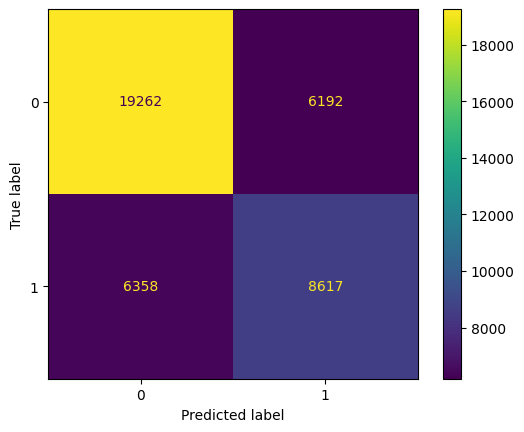

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [50]:
import xgboost as xgb

model1 = xgb.XGBClassifier()
model1.fit(X_train, y_train)
y_pred_xgb = model1.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.718914640480843
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     25454
           1       0.60      0.71      0.65     14975

    accuracy                           0.72     40429
   macro avg       0.71      0.72      0.71     40429
weighted avg       0.73      0.72      0.72     40429



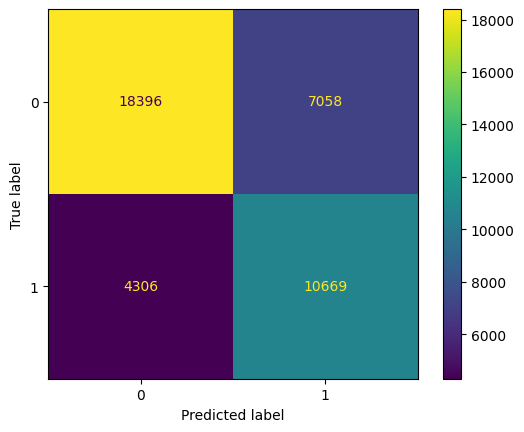

In [51]:
ConfusionMatrixDisplay.from_estimator(model1, X_test, y_test)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 
questions = list(df['question1']) + list(df['question2'])
cv = CountVectorizer()
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
temp_df1 = pd.DataFrame(q1_arr, index= df.index)
temp_df2 = pd.DataFrame(q2_arr, index= df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize, sent_tokenize
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Applying all the preprocessing methods on our questions data
stop_words = set(stopwords.words('english'))
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)